# 1. pretrain_motif.py

In [4]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable

import math, random, sys
from tqdm import tqdm
import numpy as np
from optparse import OptionParser
from gnn_model import GNN

#sys.path.append('./util/')

from mol_tree import *
from nnutils import *
from datautils import *
from motif_generation import *

import rdkit

In [5]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch implementation of pre-training of graph neural networks')
parser.add_argument('--device', type=int, default=0,
                    help='which gpu to use if any (default: 0)')
parser.add_argument('--batch_size', type=int, default=1,
                    help='input batch size for training (default: 32)')
parser.add_argument('--epochs', type=int, default=100,
                    help='number of epochs to train (default: 100)')
parser.add_argument('--lr', type=float, default=0.001,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay', type=float, default=0,
                    help='weight decay (default: 0)')
parser.add_argument('--num_layer', type=int, default=5,
                    help='number of GNN message passing layers (default: 5).')
parser.add_argument('--emb_dim', type=int, default=300,
                    help='embedding dimensions (default: 300)')
parser.add_argument('--dropout_ratio', type=float, default=0.2,
                    help='dropout ratio (default: 0.2)')
parser.add_argument('--graph_pooling', type=str, default="mean",
                    help='graph level pooling (sum, mean, max, set2set, attention)')
parser.add_argument('--JK', type=str, default="last",
                    help='how the node features across layers are combined. last, sum, max or concat')
parser.add_argument('--dataset', type=str, default='./data/zinc/CNNC.txt',
                    help='root directory of dataset. For now, only classification.')
parser.add_argument('--gnn_type', type=str, default="gin")
parser.add_argument('--input_model_file', type=str, default='./saved_model/init', help='filename to read the model (if there is any)')
parser.add_argument('--output_model_file', type=str, default='./saved_model/motif_pretrain',
                    help='filename to output the pre-trained model')
parser.add_argument('--num_workers', type=int, default=0, help='number of workers for dataset loading')   #원래는 8이었음 오류로 0으로 바꿈
parser.add_argument("--hidden_size", type=int, default=300, help='hidden size')
parser.add_argument("--latent_size", type=int, default=56, help='latent size')
parser.add_argument("--vocab", type=str, default='./data/zinc/clique.txt', help='vocab path')
parser.add_argument('--order', type=str, default="bfs",
                    help='motif tree generation order (bfs or dfs)')
args = parser.parse_args([])

In [6]:
lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)
# 치명적 오류가 발생되면 로그기록해라

def group_node_rep(node_rep, batch_index, batch_size):
    group = []
    count = 0
    for i in range(batch_size):
        num = sum(batch_index == i)
        group.append(node_rep[count:count + num])		# count += num번째 node의 표현을 그룹에 더해라
        count += num
    return group						# 최종 그룹을 출력

# 2. train()

## 2-0. mol_to_graph

In [7]:
# allowable node and edge features
allowable_features = {
    'possible_atomic_num_list': list(range(1, 119)),
    'possible_formal_charge_list': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    'possible_chirality_list': [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ],
    'possible_hybridization_list': [
        Chem.rdchem.HybridizationType.S,
        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED
    ],
    'possible_numH_list': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'possible_implicit_valence_list': [0, 1, 2, 3, 4, 5, 6],
    'possible_degree_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'possible_bonds': [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ],
    'possible_bond_dirs': [  # only for double bond stereo information
        Chem.rdchem.BondDir.NONE,
        Chem.rdchem.BondDir.ENDUPRIGHT,
        Chem.rdchem.BondDir.ENDDOWNRIGHT
    ]
}

In [8]:
def mol_to_graph_data_obj_simple(mol):
    """
    Converts rdkit mol object to graph Data object required by the pytorch
    geometric package. NB: Uses simplified atom and bond features, and represent
    as indices
    :param mol: rdkit mol object
    :return: graph data object with the attributes: x, edge_index, edge_attr
    """
    # atoms
    num_atom_features = 2  # atom type,  chirality tag
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_feature = [allowable_features['possible_atomic_num_list'].index(
            atom.GetAtomicNum())] + [allowable_features[
                                         'possible_chirality_list'].index(atom.GetChiralTag())]
        atom_features_list.append(atom_feature)
    x = torch.tensor(np.array(atom_features_list), dtype=torch.long)

    # bonds
    num_bond_features = 2  # bond type, bond direction
    if len(mol.GetBonds()) > 0:  # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_feature = [allowable_features['possible_bonds'].index(
                bond.GetBondType())] + [allowable_features[
                'possible_bond_dirs'].index(
                bond.GetBondDir())]
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = torch.tensor(np.array(edges_list).T, dtype=torch.long)

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = torch.tensor(np.array(edge_features_list),
                                 dtype=torch.long)
    else:  # mol has no bonds
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, num_bond_features), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    return data

In [9]:
def moltree_to_graph_data(batch):
    graph_data_batch = []
    for mol in batch:
        graph_data_batch.append(mol_to_graph_data_obj_simple(mol.mol))
    new_batch = Batch().from_data_list(graph_data_batch)
    return new_batch

## 2-1. MoleculeDataset (util/datautils.py)
- MoleculeDataset안에 MolTree가 있고, MolTree안에는 MolNode로 구성된다

In [10]:
import torch
from torch.utils.data import Dataset
from mol_tree import MolTree
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from torch_geometric.data import Batch
from torch_geometric.data import Data

In [11]:
smiles = 'C=NNC'
mol = Chem.MolFromSmiles(smiles)

### 2-1-1.MolTree

In [12]:
import rdkit
import rdkit.Chem as Chem
import numpy as np
import copy
from chemutils import get_clique_mol, tree_decomp, brics_decomp, get_mol, get_smiles, set_atommap, enum_assemble, decode_stereo

#### 2-1-1-1. chemutils.py

In [13]:
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import BRICS
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from collections import defaultdict
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions

MST_MAX_WEIGHT = 100
MAX_NCAND = 2000

##### 2-1-1-1-1. brics_decomp

In [14]:
def brics_decomp(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:
        return [[0]], []

    cliques = []
    breaks = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        cliques.append([a1, a2])

    res = list(BRICS.FindBRICSBonds(mol))
    if len(res) == 0:
        return [list(range(n_atoms))], []
    else:
        for bond in res:
            if [bond[0][0], bond[0][1]] in cliques:
                cliques.remove([bond[0][0], bond[0][1]])
            else:
                cliques.remove([bond[0][1], bond[0][0]])
            cliques.append([bond[0][0]])
            cliques.append([bond[0][1]])

    # break bonds between rings and non-ring atoms
    for c in cliques:
        if len(c) > 1:
            if mol.GetAtomWithIdx(c[0]).IsInRing() and not mol.GetAtomWithIdx(c[1]).IsInRing():
                cliques.remove(c)
                cliques.append([c[1]])
                breaks.append(c)
            if mol.GetAtomWithIdx(c[1]).IsInRing() and not mol.GetAtomWithIdx(c[0]).IsInRing():
                cliques.remove(c)
                cliques.append([c[0]])
                breaks.append(c)

    # select atoms at intersections as motif
    for atom in mol.GetAtoms():
        if len(atom.GetNeighbors()) > 2 and not atom.IsInRing():
            cliques.append([atom.GetIdx()])
            for nei in atom.GetNeighbors():
                if [nei.GetIdx(), atom.GetIdx()] in cliques:
                    cliques.remove([nei.GetIdx(), atom.GetIdx()])
                    breaks.append([nei.GetIdx(), atom.GetIdx()])
                elif [atom.GetIdx(), nei.GetIdx()] in cliques:
                    cliques.remove([atom.GetIdx(), nei.GetIdx()])
                    breaks.append([atom.GetIdx(), nei.GetIdx()])
                cliques.append([nei.GetIdx()])

    # merge cliques
    for c in range(len(cliques) - 1):
        if c >= len(cliques):
            break
        for k in range(c + 1, len(cliques)):
            if k >= len(cliques):
                break
            if len(set(cliques[c]) & set(cliques[k])) > 0:
                cliques[c] = list(set(cliques[c]) | set(cliques[k]))
                cliques[k] = []
        cliques = [c for c in cliques if len(c) > 0]
    cliques = [c for c in cliques if len(c) > 0]

    # edges
    edges = []
    for bond in res:
        for c in range(len(cliques)):
            if bond[0][0] in cliques[c]:
                c1 = c
            if bond[0][1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))
    for bond in breaks:
        for c in range(len(cliques)):
            if bond[0] in cliques[c]:
                c1 = c
            if bond[1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))

    return cliques, edges

In [15]:
brics_decomp(mol)

([[0, 1, 2, 3]], [])

In [16]:
def tree_decomp(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:
        return [[0]], []

    cliques = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        if not bond.IsInRing():
            cliques.append([a1, a2])

    # get rings
    ssr = [list(x) for x in Chem.GetSymmSSSR(mol)]
    cliques.extend(ssr)

    nei_list = [[] for i in range(n_atoms)]
    for i in range(len(cliques)):
        for atom in cliques[i]:
            nei_list[atom].append(i)

    # Merge Rings with intersection > 2 atoms
    for i in range(len(cliques)):
        if len(cliques[i]) <= 2: continue
        for atom in cliques[i]:
            for j in nei_list[atom]:
                if i >= j or len(cliques[j]) <= 2: continue
                inter = set(cliques[i]) & set(cliques[j])
                if len(inter) > 2:
                    cliques[i].extend(cliques[j])
                    cliques[i] = list(set(cliques[i]))
                    cliques[j] = []

    cliques = [c for c in cliques if len(c) > 0]
    nei_list = [[] for i in range(n_atoms)]
    for i in range(len(cliques)):
        for atom in cliques[i]:
            nei_list[atom].append(i)

    # Build edges and add singleton cliques
    edges = defaultdict(int)
    for atom in range(n_atoms):
        if len(nei_list[atom]) <= 1:
            continue
        cnei = nei_list[atom]
        bonds = [c for c in cnei if len(cliques[c]) == 2]
        rings = [c for c in cnei if len(cliques[c]) > 4]
        if len(bonds) > 2 or (len(bonds) == 2 and len(
                cnei) > 2):  # In general, if len(cnei) >= 3, a singleton should be added, but 1 bond + 2 ring is currently not dealt with.
            cliques.append([atom])
            c2 = len(cliques) - 1
            for c1 in cnei:
                edges[(c1, c2)] = 1
        elif len(rings) > 2:  # Multiple (n>2) complex rings
            cliques.append([atom])
            c2 = len(cliques) - 1
            for c1 in cnei:
                edges[(c1, c2)] = MST_MAX_WEIGHT - 1
        else:
            for i in range(len(cnei)):
                for j in range(i + 1, len(cnei)):
                    c1, c2 = cnei[i], cnei[j]
                    inter = set(cliques[c1]) & set(cliques[c2])
                    if edges[(c1, c2)] < len(inter):
                        edges[(c1, c2)] = len(inter)  # cnei[i] < cnei[j] by construction

    edges = [u + (MST_MAX_WEIGHT - v,) for u, v in edges.items()]
    if len(edges) == 0:
        return cliques, edges

    # Compute Maximum Spanning Tree
    row, col, data = zip(*edges)
    n_clique = len(cliques)
    clique_graph = csr_matrix((data, (row, col)), shape=(n_clique, n_clique))
    junc_tree = minimum_spanning_tree(clique_graph)
    row, col = junc_tree.nonzero()
    edges = [(row[i], col[i]) for i in range(len(row))]
    return (cliques, edges)


In [17]:
def sanitize(mol):
    try:
        smiles = get_smiles(mol)
        mol = get_mol(smiles)
    except Exception as e:
        return None
    return mol

##### 2-1-1-1-2. get_clique_mol

In [18]:
def get_clique_mol(mol, atoms):
    # get the fragment of clique
    smiles = Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True)
    new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
    new_mol = copy_edit_mol(new_mol).GetMol()
    new_mol = sanitize(new_mol)  # We assume this is not None
    return new_mol

In [19]:
atoms = mol.GetAtoms()
smiles = Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True)
new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
new_mol = copy_edit_mol(new_mol).GetMol()
new_mol = sanitize(new_mol)  # We assume this is not None

TypeError: No registered converter was able to produce a C++ rvalue of type int from this Python object of type Atom

In [20]:
# map atoms to clique
def set_atommap(mol, num=0):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(num)

#### 2-1-1-2. MolTreeNode

In [21]:
class MolTreeNode(object):

    def __init__(self, smiles, clique=[]):   #스마일식을 받고, clique(무리, 군벌 등을 의미, 여기선 원자집단 말하는 듯)라는 벡터를 받아라
        self.smiles = smiles
        self.mol = get_mol(self.smiles)  #스마일식에서 분자를 얻어내고, 이중결합등이 명시된 결과를 반환하라.
        #self.mol = cmol

        self.clique = [x for x in clique] #vocabulary.txt파일인데, motif의 vocabulary인 것 같은데?
        self.neighbors = []
        
    def add_neighbor(self, nei_node):		#인접 노드들을 이웃 변수에 추가해라
        self.neighbors.append(nei_node)	

    def recover(self, original_mol):	
        clique = []
        clique.extend(self.clique)		# clique에 자신의 clique리스트들을 추가
        if not self.is_leaf:
            for cidx in self.clique:
                original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(self.nid)	#Clique들에서 원자들의 id를 가져오고, 원자맵 숫자를 지정하라.

        for nei_node in self.neighbors:
            clique.extend(nei_node.clique)		# 위의 화학식 리스트들에 인접노드들을 추가해라
            if nei_node.is_leaf: #Leaf node, no need to mark(끄트머리꺼면 마킹할 필요 없어)
                continue
            for cidx in nei_node.clique:			# 인접노드의 분자식들에서 원자 id가져오고, 원자맵 숫자 지정(위에꺼)
                #allow singleton node override the atom mapping
                if cidx not in self.clique or len(nei_node.clique) == 1:
                    atom = original_mol.GetAtomWithIdx(cidx)
                    atom.SetAtomMapNum(nei_node.nid)

        clique = list(set(clique))		# n노드와 인접 노드들의 분자식
        label_mol = get_clique_mol(original_mol, clique)	# 그들의 레이블
        self.label = Chem.MolToSmiles(Chem.MolFromSmiles(get_smiles(label_mol)))	#아니 도대체 왜 스마일식을 얻고, 이걸 원자로 바꾸고, 다시 원자를 스마일 식으로 바꾸냐고...
        self.label_mol = get_mol(self.label)

        for cidx in clique:
            original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(0)		#원본 분자의 원자 id를 얻고, 원자맵 숫자는 0으로

        return self.label		#레이블 스마일식을 레이블로 반환하라
    
    def assemble(self):
        neighbors = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() > 1]
        neighbors = sorted(neighbors, key=lambda x:x.mol.GetNumAtoms(), reverse=True)
        singletons = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() == 1]
        neighbors = singletons + neighbors

        cands = enum_assemble(self, neighbors)
        if len(cands) > 0:
            self.cands, self.cand_mols, _ = zip(*cands)
            self.cands = list(self.cands)
            self.cand_mols = list(self.cand_mols)
        else:
            self.cands = []
            self.cand_mols = []

#### 2-1-1. MolTree코드

In [22]:
class MolTree(object):

    def __init__(self, smiles):
        self.smiles = smiles
        self.mol = get_mol(smiles)

        '''
        #Stereo Generation
        mol = Chem.MolFromSmiles(smiles)
        self.smiles3D = Chem.MolToSmiles(mol, isomericSmiles=True)
        self.smiles2D = Chem.MolToSmiles(mol)
        self.stereo_cands = decode_stereo(self.smiles2D)
        '''

        cliques, edges = brics_decomp(self.mol)
        if len(edges) <= 1:
            cliques, edges = tree_decomp(self.mol)
        self.nodes = []
        root = 0
        for i,c in enumerate(cliques):
            cmol = get_clique_mol(self.mol, c)
            node = MolTreeNode(get_smiles(cmol), c)
            self.nodes.append(node)
            if min(c) == 0:
                root = i

        for x,y in edges:
            self.nodes[x].add_neighbor(self.nodes[y])
            self.nodes[y].add_neighbor(self.nodes[x])
        
        if root > 0:
            self.nodes[0],self.nodes[root] = self.nodes[root],self.nodes[0]

        for i,node in enumerate(self.nodes):
            node.nid = i + 1
            if len(node.neighbors) > 1: #Leaf node mol is not marked
                set_atommap(node.mol, node.nid)
            node.is_leaf = (len(node.neighbors) == 1)

    def size(self):
        return len(self.nodes)

    def recover(self):
        for node in self.nodes:
            node.recover(self.mol)

    def assemble(self):
        for node in self.nodes:
            node.assemble()

### 2-1.MoleculeDataset()

In [23]:
class MoleculeDataset(Dataset):

    def __init__(self, data_file):
        with open(data_file) as f:
            self.data = [line.strip("\r\n ").split()[0] for line in f]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles = self.data[idx]
        mol_tree = MolTree(smiles)
        mol_tree.recover()
        mol_tree.assemble()
        return mol_tree

### 2-1. !(중요) MolData 예제

In [24]:
dataset = MoleculeDataset(args.dataset)
dataset

In [25]:
dataset[0]

In [26]:
dataset[0].smiles

'C=NNC'

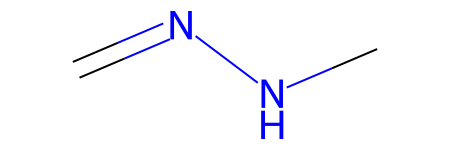

In [27]:
dataset[0].mol

In [28]:
dataset[0].nodes

In [29]:
dataset[0].size()

3

In [30]:
dataset[0].recover()

In [31]:
for i in range(3):
    print(dataset[0].nodes[i].clique)

[0, 1]
[1, 2]
[2, 3]


In [32]:
for i in range(3):
    print(dataset[0].nodes[i].neighbors)

[<__main__.MolTreeNode object at 0x7f0744641d50>, <__main__.MolTreeNode object at 0x7f0744641190>]


In [33]:
for i in range(3):
    print(dataset[0].nodes[i].label)

C=N[NH2:2]
C=[N:2][NH:2]C
CN[NH2:2]


## 2-2. GNN(gnn_model.py)
- GNN(args.num_layer, args.emb_dim, JK=args.JK, drop_ratio=args.dropout_ratio, gnn_type=args.gnn_type).to(device)
- 보니깐 GIN 5개층, 300이 finetune과 동일한 것으로 예상(당연하겠지만) finetune에서 했으므로 pass

In [34]:
print(args.num_layer, args.emb_dim, args.JK, args.dropout_ratio, args.gnn_type)

5 300 last 0.2 gin


In [35]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, softmax
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
import torch.nn.functional as F
from torch_scatter import scatter_add
from torch_geometric.nn.inits import glorot, zeros

num_atom_type = 120 #including the extra mask tokens
num_chirality_tag = 3

num_bond_type = 6 #including aromatic and self-loop edge, and extra masked tokens
num_bond_direction = 3 

In [36]:
class GINConv(MessagePassing):
    """
    Extension of GIN aggregation to incorporate edge information by concatenation.

    Args:
        emb_dim (int): dimensionality of embeddings for nodes and edges.
        embed_input (bool): whether to embed input or not. 
        

    See https://arxiv.org/abs/1810.00826
    """
    def __init__(self, emb_dim, aggr = "add"):
        super(GINConv, self).__init__()
        #multi-layer perceptron
        self.mlp = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*emb_dim, emb_dim))
        self.edge_embedding1 = torch.nn.Embedding(num_bond_type, emb_dim)
        self.edge_embedding2 = torch.nn.Embedding(num_bond_direction, emb_dim)

        torch.nn.init.xavier_uniform_(self.edge_embedding1.weight.data)
        torch.nn.init.xavier_uniform_(self.edge_embedding2.weight.data)
        self.aggr = aggr

    def forward(self, x, edge_index, edge_attr):
        #add self loops in the edge space
        edge_index = add_self_loops(edge_index, num_nodes = x.size(0))

        #add features corresponding to self-loop edges.
        self_loop_attr = torch.zeros(x.size(0), 2)
        self_loop_attr[:,0] = 4 #bond type for self-loop edge
        self_loop_attr = self_loop_attr.to(edge_attr.device).to(edge_attr.dtype)
        edge_attr = torch.cat((edge_attr, self_loop_attr), dim = 0)

        edge_embeddings = self.edge_embedding1(edge_attr[:,0]) + self.edge_embedding2(edge_attr[:,1])

        return self.propagate(edge_index[0], x=x, edge_attr=edge_embeddings)

    def message(self, x_j, edge_attr):
        return x_j + edge_attr

    def update(self, aggr_out):
        return self.mlp(aggr_out)


In [37]:
class GNN(torch.nn.Module):
    """
    

    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        JK (str): last, concat, max or sum.
        max_pool_layer (int): the layer from which we use max pool rather than add pool for neighbor aggregation
        drop_ratio (float): dropout rate
        gnn_type: gin, gcn, graphsage, gat

    Output:
        node representations

    """
    def __init__(self, num_layer, emb_dim, JK = "last", drop_ratio = 0, gnn_type = "gin"):
        super(GNN, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        self.x_embedding1 = torch.nn.Embedding(num_atom_type, emb_dim)
        self.x_embedding2 = torch.nn.Embedding(num_chirality_tag, emb_dim)

        torch.nn.init.xavier_uniform_(self.x_embedding1.weight.data)
        torch.nn.init.xavier_uniform_(self.x_embedding2.weight.data)

        ###List of MLPs
        self.gnns = torch.nn.ModuleList()
        for layer in range(num_layer):
            if gnn_type == "gin":
                self.gnns.append(GINConv(emb_dim, aggr = "add"))
            elif gnn_type == "gcn":
                self.gnns.append(GCNConv(emb_dim))
            elif gnn_type == "gat":
                self.gnns.append(GATConv(emb_dim))
            elif gnn_type == "graphsage":
                self.gnns.append(GraphSAGEConv(emb_dim))

        ###List of batchnorms
        self.batch_norms = torch.nn.ModuleList()
        for layer in range(num_layer):
            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))

    #def forward(self, x, edge_index, edge_attr):
    def forward(self, *argv):
        if len(argv) == 3:
            x, edge_index, edge_attr = argv[0], argv[1], argv[2]
        elif len(argv) == 1:
            data = argv[0]
            x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        else:
            raise ValueError("unmatched number of arguments.")

        x = self.x_embedding1(x[:,0]) + self.x_embedding2(x[:,1])

        h_list = [x]
        for layer in range(self.num_layer):
            h = self.gnns[layer](h_list[layer], edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            #h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            if layer == self.num_layer - 1:
                #remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            h_list.append(h)

        ### Different implementations of Jk-concat   #레이어간 노드 기능들을 어떻게 할건지, 기본은 Last다
        if self.JK == "concat":
            node_representation = torch.cat(h_list, dim = 1)
        elif self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "max":
            h_list = [h.unsqueeze_(0) for h in h_list]
            node_representation = torch.max(torch.cat(h_list, dim = 0), dim = 0)[0]
        elif self.JK == "sum":
            h_list = [h.unsqueeze_(0) for h in h_list]
            node_representation = torch.sum(torch.cat(h_list, dim = 0), dim = 0)[0]

        return node_representation

## 2-3. !(중요) Motif_Generation (motif_generation.py)

In [38]:
import torch
import torch.nn as nn
from mol_tree import Vocab, MolTree
from nnutils import create_var
from dfs import Motif_Generation_dfs
from bfs import Motif_Generation_bfs
from chemutils import enum_assemble, set_atommap, copy_edit_mol, attach_mols, atom_equal, decode_stereo
import rdkit
import rdkit.Chem as Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import copy, math

### 2-3-1. Vocab클래스

In [39]:
import rdkit
import rdkit.Chem as Chem
import numpy as np
import copy
from chemutils import get_clique_mol, tree_decomp, brics_decomp, get_mol, get_smiles, set_atommap, enum_assemble, decode_stereo

def get_slots(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return [(atom.GetSymbol(), atom.GetFormalCharge(), atom.GetTotalNumHs()) for atom in mol.GetAtoms()]


In [40]:
class Vocab(object):

    def __init__(self, smiles_list):
        self.vocab = smiles_list
        self.vmap = {x:i for i,x in enumerate(self.vocab)}
        self.slots = [get_slots(smiles) for smiles in self.vocab]
        
    def get_index(self, smiles):
        return self.vmap[smiles]

    def get_smiles(self, idx):
        return self.vocab[idx]

    def get_slots(self, idx):
        return copy.deepcopy(self.slots[idx])

    def size(self):
        return len(self.vocab)

In [41]:
vocab_origin = [x.strip("\r\n ") for x in open(args.vocab)]
vocab = Vocab(vocab_origin)

In [39]:
vocab_origin

['C1=CC=C(C2=NC(C3=CC=CC=C3)=NC=C2)C=C1',
 'CC1=NC2=CC=CC=C2O1',
 'C1OC2CC3CC1C2C3',
 'C1=CN=C(N2CCCCC2)N=C1',
 'C1=CN=C2C=C[NH]C2=C1',
 'C1=NN2C=NC3=C(C=CO3)C2=N1',
 'NC1=CC2=CC=CC=C2C=N1',
 'C1=CC=C(C2=NC=C[NH]2)C=C1',
 'NC1=NC(C2=CC=CC=N2)=NC2=C1CC[NH2+]CC2',
 'C1=CC=C2OC(C3CCC[NH2+]3)=NC2=C1',
 'C1=NC2=C(C=N1)N=C[NH]2',
 'CC1OC2COC(N3C=NC4=C3N=CNC4)C2O1',
 'C1=CC=C(C2CCC3=C(C2)NC2=NC=NN2C3C2=CC=CC=C2)C=C1',
 'CC1CC2CC3=CC=CC4=C3C(CO4)(C1)C2',
 'C1=N[NH]C(C2CCC[NH2+]2)=C1',
 'NC1=NC2=C(CCC3=CC=CC=C32)S1',
 'C1=CC=C(C2C[NH2+]CCN2)C=C1',
 'C1=CC(N2C=NN=N2)=CC=C1N1CCCCC1',
 'C1=CC2CCC2C1',
 'NC1=CC=CC(C2=NN=CS2)=C1',
 'C1=CC=C(C2=CSC(C3=CC=CC=C3)=N2)C=C1',
 'C1=NN2CC[NH2+]CC2=C1',
 'NC1=CNN(C2=CC=CC=C2)C1',
 'C1=CC2=C(CCCC2N2CCOCC2)S1',
 'C1=CC=C2C(=C1)C=NC1=CC=CC=C12',
 'C1=CC(C2=CC=CC=C2)C2=CC3=C(C=C2O1)OCO3',
 'C1=CC=C(C2=CSC(N3C=CN=N3)=N2)C=C1',
 'NC1=NC2=CC=CC=C2N2N=NN=C12',
 'C1=CC=C(C2=CN=CC3=CC=CC=C23)C=C1',
 'C1CSSCCNN1',
 'C1=CC(C2=CC=CC=C2)[NH+]=N1',
 'SC1=NC(N2C=CC3=C(C=NC4

In [40]:
vocab

In [41]:
vocab.vocab

['C1=CC=C(C2=NC(C3=CC=CC=C3)=NC=C2)C=C1',
 'CC1=NC2=CC=CC=C2O1',
 'C1OC2CC3CC1C2C3',
 'C1=CN=C(N2CCCCC2)N=C1',
 'C1=CN=C2C=C[NH]C2=C1',
 'C1=NN2C=NC3=C(C=CO3)C2=N1',
 'NC1=CC2=CC=CC=C2C=N1',
 'C1=CC=C(C2=NC=C[NH]2)C=C1',
 'NC1=NC(C2=CC=CC=N2)=NC2=C1CC[NH2+]CC2',
 'C1=CC=C2OC(C3CCC[NH2+]3)=NC2=C1',
 'C1=NC2=C(C=N1)N=C[NH]2',
 'CC1OC2COC(N3C=NC4=C3N=CNC4)C2O1',
 'C1=CC=C(C2CCC3=C(C2)NC2=NC=NN2C3C2=CC=CC=C2)C=C1',
 'CC1CC2CC3=CC=CC4=C3C(CO4)(C1)C2',
 'C1=N[NH]C(C2CCC[NH2+]2)=C1',
 'NC1=NC2=C(CCC3=CC=CC=C32)S1',
 'C1=CC=C(C2C[NH2+]CCN2)C=C1',
 'C1=CC(N2C=NN=N2)=CC=C1N1CCCCC1',
 'C1=CC2CCC2C1',
 'NC1=CC=CC(C2=NN=CS2)=C1',
 'C1=CC=C(C2=CSC(C3=CC=CC=C3)=N2)C=C1',
 'C1=NN2CC[NH2+]CC2=C1',
 'NC1=CNN(C2=CC=CC=C2)C1',
 'C1=CC2=C(CCCC2N2CCOCC2)S1',
 'C1=CC=C2C(=C1)C=NC1=CC=CC=C12',
 'C1=CC(C2=CC=CC=C2)C2=CC3=C(C=C2O1)OCO3',
 'C1=CC=C(C2=CSC(N3C=CN=N3)=N2)C=C1',
 'NC1=NC2=CC=CC=C2N2N=NN=C12',
 'C1=CC=C(C2=CN=CC3=CC=CC=C23)C=C1',
 'C1CSSCCNN1',
 'C1=CC(C2=CC=CC=C2)[NH+]=N1',
 'SC1=NC(N2C=CC3=C(C=NC4

In [42]:
vocab.vmap

{'C1=CC=C(C2=NC(C3=CC=CC=C3)=NC=C2)C=C1': 0,
 'CC1=NC2=CC=CC=C2O1': 1,
 'C1OC2CC3CC1C2C3': 2,
 'C1=CN=C(N2CCCCC2)N=C1': 3,
 'C1=CN=C2C=C[NH]C2=C1': 4,
 'C1=NN2C=NC3=C(C=CO3)C2=N1': 5,
 'NC1=CC2=CC=CC=C2C=N1': 6,
 'C1=CC=C(C2=NC=C[NH]2)C=C1': 7,
 'NC1=NC(C2=CC=CC=N2)=NC2=C1CC[NH2+]CC2': 8,
 'C1=CC=C2OC(C3CCC[NH2+]3)=NC2=C1': 9,
 'C1=NC2=C(C=N1)N=C[NH]2': 10,
 'CC1OC2COC(N3C=NC4=C3N=CNC4)C2O1': 11,
 'C1=CC=C(C2CCC3=C(C2)NC2=NC=NN2C3C2=CC=CC=C2)C=C1': 12,
 'CC1CC2CC3=CC=CC4=C3C(CO4)(C1)C2': 13,
 'C1=N[NH]C(C2CCC[NH2+]2)=C1': 14,
 'NC1=NC2=C(CCC3=CC=CC=C32)S1': 15,
 'C1=CC=C(C2C[NH2+]CCN2)C=C1': 16,
 'C1=CC(N2C=NN=N2)=CC=C1N1CCCCC1': 17,
 'C1=CC2CCC2C1': 18,
 'NC1=CC=CC(C2=NN=CS2)=C1': 19,
 'C1=CC=C(C2=CSC(C3=CC=CC=C3)=N2)C=C1': 20,
 'C1=NN2CC[NH2+]CC2=C1': 21,
 'NC1=CNN(C2=CC=CC=C2)C1': 22,
 'C1=CC2=C(CCCC2N2CCOCC2)S1': 23,
 'C1=CC=C2C(=C1)C=NC1=CC=CC=C12': 24,
 'C1=CC(C2=CC=CC=C2)C2=CC3=C(C=C2O1)OCO3': 25,
 'C1=CC=C(C2=CSC(N3C=CN=N3)=N2)C=C1': 26,
 'NC1=NC2=CC=CC=C2N2N=NN=C12': 27,
 'C1=

In [43]:
vocab.slots

[[('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 0),
  ('C', 0, 0),
  ('N', 0, 0),
  ('C', 0, 0),
  ('C', 0, 0),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 1),
  ('N', 0, 0),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 1)],
 [('C', 0, 3),
  ('C', 0, 0),
  ('N', 0, 0),
  ('C', 0, 0),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 0),
  ('O', 0, 0)],
 [('C', 0, 2),
  ('O', 0, 0),
  ('C', 0, 1),
  ('C', 0, 2),
  ('C', 0, 1),
  ('C', 0, 2),
  ('C', 0, 1),
  ('C', 0, 1),
  ('C', 0, 2)],
 [('C', 0, 1),
  ('C', 0, 1),
  ('N', 0, 0),
  ('C', 0, 0),
  ('N', 0, 0),
  ('C', 0, 2),
  ('C', 0, 2),
  ('C', 0, 2),
  ('C', 0, 2),
  ('C', 0, 2),
  ('N', 0, 0),
  ('C', 0, 1)],
 [('C', 0, 1),
  ('C', 0, 1),
  ('N', 0, 0),
  ('C', 0, 0),
  ('C', 0, 1),
  ('C', 0, 1),
  ('N', 0, 1),
  ('C', 0, 0),
  ('C', 0, 1)],
 [('C', 0, 1),
  ('N', 0, 0),
  ('N', 0, 0),
  ('C', 0, 1),
  ('N', 0, 0),
  ('C', 0, 0),
  ('C', 0, 0),
  ('C', 0, 1),
  ('C

In [44]:
vocab.get_index('C=NNC')

104

In [45]:
args.vocab

'./data/zinc/clique.txt'

In [46]:
def set_batch_nodeID(mol_batch, vocab):
    tot = 0
    for mol_tree in mol_batch:
        for node in mol_tree.nodes:
            node.idx = tot
            node.wid = vocab.get_index(node.smiles)
            tot += 1

### 2-3-. bfs디코더

In [42]:
import torch
import torch.nn as nn
from mol_tree import Vocab, MolTree, MolTreeNode
from nnutils import create_var, GRU
from chemutils import enum_assemble
import copy

MAX_NB = 8
MAX_DECODE_LEN = 100

In [43]:
class Motif_Generation_bfs(nn.Module):

    def __init__(self, vocab, hidden_size, device):
        super(Motif_Generation_bfs, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab.size()
        self.vocab = vocab
        self.device = device

        # GRU Weights(GRU 가중치)
        self.W_z = nn.Linear(2 * hidden_size, hidden_size)
        self.U_r = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_r = nn.Linear(hidden_size, hidden_size)
        self.W_h = nn.Linear(2 * hidden_size, hidden_size)

        # Feature Aggregate Weights(특성 집계 가중치)
        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(2 * hidden_size, hidden_size)

        # Output Weights(출력 가중치)
        self.W_o = nn.Linear(hidden_size, self.vocab_size+1)
        # bfs add one stop node
        self.U_s = nn.Linear(hidden_size, 1)

        # Loss Functions
        self.pred_loss = nn.CrossEntropyLoss(size_average=False)
        self.stop_loss = nn.BCEWithLogitsLoss(size_average=False)

    def get_trace(self, node):
        super_root = MolTreeNode("")
        super_root.idx = -1
        trace = []
        bfs(trace, node, super_root)
        return [(x.smiles, y.smiles, z) for x, y, z in trace]

    def forward(self, mol_batch, node_rep):
        super_root = MolTreeNode("")
        super_root.idx = -1

        # Initialize
        pred_hiddens, pred_targets = [], []
        stop_hiddens, stop_targets = [], []
        traces = []
        for mol_tree in mol_batch:
            s = []
            bfs(s, mol_tree.nodes[0], super_root)
            traces.append(s)
            for node in mol_tree.nodes:
                node.neighbors = []
        '''
        # Predict Root
        pred_hiddens.append(create_var(torch.zeros(len(mol_batch), self.hidden_size)))
        pred_targets.extend([mol_tree.nodes[0].wid for mol_tree in mol_batch])
        pred_mol_vecs.append(mol_vec)
        '''

        max_iter = max([len(tr) for tr in traces])
        padding = create_var(torch.zeros(self.hidden_size), False)
        stop_embedding = create_var(torch.zeros(self.hidden_size), True)
        h = {}

        for t in range(max_iter):
            prop_list = []
            batch_list = []
            for i, plist in enumerate(traces):
                if t < len(plist):
                    prop_list.append(plist[t])
                    batch_list.append(i)
                else:
                    prop_list.append(None)

            em_list = []
            cur_h_nei, cur_o_nei = [], []

            for mol_index, prop in enumerate(prop_list):
                if prop is None:
                    continue
                node_x, real_y, _ = prop
                # Neighbors for message passing (target not included)
                cur_nei = [h[(node_y.idx, node_x.idx)] for node_y in node_x.neighbors if node_y.idx != real_y.idx]
                pad_len = MAX_NB - len(cur_nei)
                if pad_len>= 0:
                    cur_h_nei.extend(cur_nei)
                    cur_h_nei.extend([padding] * pad_len)
                else:
                    cur_h_nei.extend(cur_nei[:MAX_NB])

                # Neighbors for stop prediction (all neighbors)
                '''
                cur_nei = [h[(node_y.idx, node_x.idx)] for node_y in node_x.neighbors]
                pad_len = MAX_NB - len(cur_nei)
                if pad_len >= 0:
                    cur_o_nei.extend(cur_nei)
                    cur_o_nei.extend([padding] * pad_len)
                else:
                    cur_o_nei.extend(cur_nei[:MAX_NB])
                '''
                # Current clique embedding
                em_list.append(torch.sum(node_rep[mol_index].index_select(0, torch.tensor(node_x.clique).to(self.device)), dim=0))

            # Clique embedding
            cur_x = torch.stack(em_list, dim=0)

            # Message passing
            cur_h_nei = torch.stack(cur_h_nei, dim=0).view(-1, MAX_NB, self.hidden_size)
            new_h = GRU(cur_x, cur_h_nei, self.W_z, self.W_r, self.U_r, self.W_h)

            # Node Aggregate
            '''
            cur_o_nei = torch.stack(cur_o_nei, dim=0).view(-1, MAX_NB, self.hidden_size)
            cur_o = cur_o_nei.sum(dim=1)
            '''
            # Gather targets
            pred_target, pred_list = [], []
            prop_list = [x for x in prop_list if x is not None]
            for i, m in enumerate(prop_list):
                node_x, node_y, direction = m
                x, y = node_x.idx, node_y.idx
                h[(x, y)] = new_h[i]
                node_y.neighbors.append(node_x)
                if direction == 1:
                    pred_target.append(node_y.wid)
                    pred_list.append(i)
                if direction == 2:
                    pred_target.append(self.vocab_size)
                    pred_list.append(i)

            # Hidden states for stop prediction
            '''
            stop_hidden = torch.cat([cur_x, cur_o], dim=1)
            stop_hiddens.append(stop_hidden)
            stop_targets.extend(stop_target)
            '''
            # Hidden states for clique prediction
            if len(pred_list) > 0:
                #batch_list = [batch_list[i] for i in pred_list]
                #cur_batch = create_var(torch.LongTensor(batch_list))
                #pred_mol_vecs.append(mol_vec.index_select(0, cur_batch))

                cur_pred = create_var(torch.LongTensor(pred_list))
                pred_hiddens.append(new_h.index_select(0, cur_pred))
                pred_targets.extend(pred_target)

        # Predict next clique
        pred_hiddens = torch.cat(pred_hiddens, dim=0)
        #pred_mol_vecs = torch.cat(pred_mol_vecs, dim=0)
        #pred_vecs = torch.cat([pred_hiddens, pred_mol_vecs], dim=1)
        pred_vecs = pred_hiddens
        pred_vecs = nn.ReLU()(self.W(pred_vecs))
        pred_scores = self.W_o(pred_vecs)
        pred_targets = create_var(torch.LongTensor(pred_targets))

        pred_loss = self.pred_loss(pred_scores, pred_targets) / len(mol_batch)
        _, preds = torch.max(pred_scores, dim=1)
        pred_acc = torch.eq(preds, pred_targets).float()
        pred_acc = torch.sum(pred_acc) / pred_targets.nelement()

        # Predict stop
        '''
        stop_hiddens = torch.cat(stop_hiddens, dim=0)
        stop_vecs = nn.ReLU()(self.U(stop_hiddens))
        stop_scores = self.U_s(stop_vecs).squeeze()
        stop_targets = create_var(torch.Tensor(stop_targets))

        stop_loss = self.stop_loss(stop_scores, stop_targets) / len(mol_batch)
        stops = torch.ge(stop_scores, 0).float()
        stop_acc = torch.eq(stops, stop_targets).float()
        stop_acc = torch.sum(stop_acc) / stop_targets.nelement()'''
        stop_loss = 0
        stop_acc = 0

        return pred_loss, stop_loss, pred_acc.item(), stop_acc

In [44]:
def dfs(stack, x, fa):
    for y in x.neighbors:
        if y.idx == fa.idx:
            continue
        stack.append((x, y, 1))
        dfs(stack, y, x)
        stack.append((y, x, 0))


def bfs(stack, x, fa):
    stop_node = MolTreeNode("")
    stop_node.idx = -2
    current_layer = [[x, fa]]
    next_layer = []
    while len(current_layer) > 0:
        for active_node in current_layer:
            x = active_node[0]
            fa = active_node[1]
            for y in x.neighbors:
                if y.idx == fa.idx:
                    continue
                stack.append((x, y, 1))
                stack.append((y, x, 0))
                next_layer.append([y, x])
                #[node in the next layer, its parent node]
            stack.append((x, stop_node, 2))
        # 2 denotes stop nodes
        current_layer = next_layer
        next_layer = []



def have_slots(fa_slots, ch_slots):
    if len(fa_slots) > 2 and len(ch_slots) > 2:
        return True
    matches = []
    for i, s1 in enumerate(fa_slots):
        a1, c1, h1 = s1
        for j, s2 in enumerate(ch_slots):
            a2, c2, h2 = s2
            if a1 == a2 and c1 == c2 and (a1 != "C" or h1 + h2 >= 4):
                matches.append((i, j))

    if len(matches) == 0: return False

    fa_match, ch_match = zip(*matches)
    if len(set(fa_match)) == 1 and 1 < len(fa_slots) <= 2:  # never remove atom from ring
        fa_slots.pop(fa_match[0])
    if len(set(ch_match)) == 1 and 1 < len(ch_slots) <= 2:  # never remove atom from ring
        ch_slots.pop(ch_match[0])

    return True


def can_assemble(node_x, node_y):
    neis = node_x.neighbors + [node_y]
    for i, nei in enumerate(neis):
        nei.nid = i

    neighbors = [nei for nei in neis if nei.mol.GetNumAtoms() > 1]
    neighbors = sorted(neighbors, key=lambda x: x.mol.GetNumAtoms(), reverse=True)
    singletons = [nei for nei in neis if nei.mol.GetNumAtoms() == 1]
    neighbors = singletons + neighbors
    cands = enum_assemble(node_x, neighbors)
    return len(cands) > 0

### 2-3. Motif_Generation코드
- 각 노드에 ID를 생성

In [45]:
class Motif_Generation(nn.Module):

    def __init__(self, vocab, hidden_size, latent_size, depth, device, order):
        super(Motif_Generation, self).__init__()
        self.vocab = vocab
        self.hidden_size = hidden_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.depth = depth
        self.device = device
        if order == 'dfs':
            self.decoder = Motif_Generation_dfs(vocab, hidden_size, self.device)
        elif order == 'bfs':
            self.decoder = Motif_Generation_bfs(vocab, hidden_size, self.device)

    def forward(self, mol_batch, node_rep):
        set_batch_nodeID(mol_batch, self.vocab)

        word_loss, topo_loss, word_acc, topo_acc = self.decoder(mol_batch, node_rep)

        loss = word_loss + topo_loss

        return loss, word_acc, topo_acc

## 2-. train 함수
- motif_model : Motif_Generation
- 흐름이 데이터에서 나온 moltree를 graph_data로 만들고
- 이를 인코더에 넣어서 노드를 임베딩 공간으로 넣는다.
- 여기서 나온 노드 임베딩을 motif_model로 넣어서 나오는 결과가 motif에 대한 

In [46]:
def train(args, model_list, loader, optimizer_list, device):
    model, motif_model = model_list                             # 훈련간 사용 모델은 GNN모델과 motif모델이다.
    optimizer_model, optimizer_motif = optimizer_list        # 옵티마이저도 둘에 대해 각각 사용하라.

    model.train()					#모델, 모티프 모델 훈련!
    motif_model.train()
    word_acc, topo_acc = 0, 0			# 분자와 위상 정확도 변수 설정
    for step, batch in enumerate(tqdm(loader, desc="Iteration")):	# 데이터로더에서 순회 진행바 표시형태로 순회해서 step과 batch대로 반복하자

        batch_size = len(batch)

        graph_batch = moltree_to_graph_data(batch)		# 분자식을 파이토치 지오메트릭 패키지에서 요구되는 그래프 데이터 형태로 변경해서 배치단위로 저장   /datautils에 있음
        #store graph object data in the process stage	
        batch_index = graph_batch.batch.numpy()			# 배치내의 배치텐서를 넘파이로 인덱스에 넘겨라
        graph_batch = graph_batch.to(device)			# 그래프배치는 GPU로 되게
        node_rep = model(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr)	# GNN모델에 그래프(x, 엣지인덱스, 엣지의 특성) 투입
        node_rep = group_node_rep(node_rep, batch_index, batch_size)			# rep는 representation의 줄임말로 노드 표현을 의미
        loss, wacc, tacc = motif_model(batch, node_rep)		# motif모델에서 손실, motif정확도, 위상 정확도 출력

        optimizer_model.zero_grad()				#옵티마이저 0으로
        optimizer_motif.zero_grad()
	
        loss.backward()					#손실 역전파

        optimizer_model.step()				#옵티마이저 시행
        optimizer_motif.step()

        word_acc += wacc
        topo_acc += tacc					#위상 정확도

        if (step+1) % 20 == 0:
            word_acc = word_acc / 20 * 100
            topo_acc = topo_acc / 20 * 100
            print("Loss: %.1f, Word: %.2f, Topo: %.2f" % (loss, word_acc, topo_acc))
            word_acc, topo_acc = 0, 0

# pretrain_motif 코드

In [47]:
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

dataset = MoleculeDataset(args.dataset)

loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, collate_fn=lambda x:x, drop_last=True)

model = GNN(args.num_layer, args.emb_dim, JK=args.JK, drop_ratio=args.dropout_ratio, gnn_type=args.gnn_type).to(device)
if not args.input_model_file == "":
    model.load_state_dict(torch.load(args.input_model_file + ".pth"))

vocab = [x.strip("\r\n ") for x in open(args.vocab)]
vocab = Vocab(vocab)
motif_model = Motif_Generation(vocab, args.hidden_size, args.latent_size, 3, device, args.order).to(device)

model_list = [model, motif_model]
optimizer_model = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.decay)
optimizer_motif = optim.Adam(motif_model.parameters(), lr=1e-3, weight_decay=args.decay)

optimizer_list = [optimizer_model, optimizer_motif]

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [57]:
model.gnns[0]

GINConv()

In [49]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, collate_fn=lambda x:x, drop_last=True)
for step, batch in enumerate(tqdm(loader, desc="Iteration")):	# 데이터로더에서 순회 진행바 표시형태로 순회해서 step과 batch대로 반복하자
    batch_origin = batch
    batch_size = len(batch)

    graph_batch = moltree_to_graph_data(batch)		# 분자식을 파이토치 지오메트릭 패키지에서 요구되는 그래프 데이터 형태로 변경해서 배치단위로 저장   /datautils에 있음
    #store graph object data in the process stage	
    batch_index = graph_batch.batch.numpy()			# 배치내의 배치텐서를 넘파이로 인덱스에 넘겨라
    graph_batch2 = graph_batch.to(device)			# 그래프배치는 GPU로 되게
    node_rep = model(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr)	# GNN모델에 그래프(x, 엣지인덱스, 엣지의 특성) 투입
    node_rep2 = group_node_rep(node_rep, batch_index, batch_size)			# rep는 representation의 줄임말로 노드 표현을 의미
    loss, wacc, tacc = motif_model(batch_origin, node_rep2)

Iteration: 100%|██████████| 10/10 [00:00<00:00, 15.78it/s]


In [54]:
batch_origin[0].smiles

'C=NNC'

In [55]:
graph_batch

Batch(batch=[4], edge_attr=[6, 2], edge_index=[2, 6], ptr=[2], x=[4, 2])

In [56]:
graph_batch.batch

tensor([0, 0, 0, 0], device='cuda:0')

In [57]:
graph_batch.edge_attr

tensor([[1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]], device='cuda:0')

In [58]:
graph_batch.edge_index

tensor([[0, 1, 1, 2, 2, 3],
        [1, 0, 2, 1, 3, 2]], device='cuda:0')

In [59]:
graph_batch.ptr

tensor([0, 4], device='cuda:0')

In [60]:
graph_batch.x

tensor([[5, 0],
        [6, 0],
        [6, 0],
        [5, 0]], device='cuda:0')

In [61]:
node_rep

tensor([[-0.4560,  0.4268,  0.3232,  ..., -0.1822,  0.5801, -0.0000],
        [-0.2668, -0.0236,  0.0000,  ..., -0.1699,  0.2065, -0.1688],
        [ 0.3180, -0.0767, -0.6251,  ...,  0.0680, -0.3360, -0.0000],
        [ 0.3903, -0.0000,  0.1493,  ...,  0.3527, -0.4213,  0.6726]],
       device='cuda:0', grad_fn=<FusedDropoutBackward0>)

In [62]:
node_rep2

[tensor([[-0.4560,  0.4268,  0.3232,  ..., -0.1822,  0.5801, -0.0000],
         [-0.2668, -0.0236,  0.0000,  ..., -0.1699,  0.2065, -0.1688],
         [ 0.3180, -0.0767, -0.6251,  ...,  0.0680, -0.3360, -0.0000],
         [ 0.3903, -0.0000,  0.1493,  ...,  0.3527, -0.4213,  0.6726]],
        device='cuda:0', grad_fn=<SliceBackward0>)]

In [63]:
loss

tensor(47.1259, device='cuda:0', grad_fn=<AddBackward0>)

In [64]:
wacc

0.0

In [65]:
tacc

0

In [66]:
for epoch in range(0, 1):
    print("====epoch " + str(epoch))

    train(args, model_list, loader, optimizer_list, device)

    if not args.output_model_file == "":
        torch.save(model.state_dict(), args.output_model_file + ".pth")

====epoch 0


Iteration: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.82it/s]


# clique만들기

In [76]:
import sys
import csv
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

cset = set()
counts = {}
num=1

print("start")
with open("../../grover/data/pretraindata.csv", "r") as f:
    for line in f.readlines():
        if num%10001==0:break
        line = line.strip('\n')
        if line=="smiles":continue
        
        #print(line)
        mol = MolTree(line)
        for c in mol.nodes:
            cset.add(c.smiles)
            if c.smiles not in counts:
                counts[c.smiles] = 1
            else:
                counts[c.smiles] += 1
        num+=1
print("Preprocessing Completed!")
clique_list = list(cset)

start
Preprocessing Completed!


In [77]:
with open('clique.txt', 'w') as file:
    for c in clique_list:
        file.write(c)
        file.write('\n')